In [1]:
#As good as our selections may be, we're likely to have some background
#contamination. Here we will look as using statistical methods to separate
#the remaining components in the data.

#We will use the zfit package to fit this data

import zfit

/home/mmccann/work/teaching/labs/trial/labs/lib/python3.10/site-packages/zfit/__init__.py:63: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


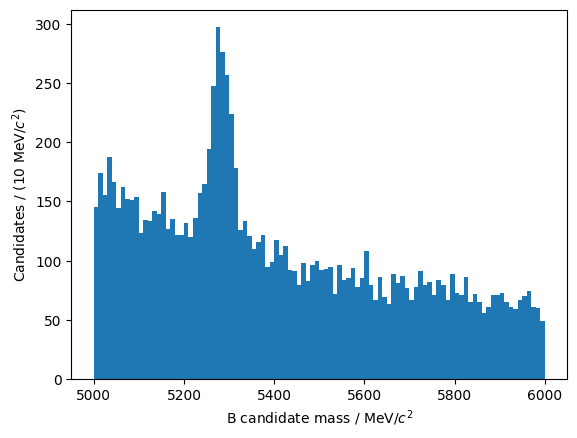

In [2]:
#This is just using some example data. You should use selected data from your
#dataset

import toydata
data = toydata.getExampleDataSet()

from matplotlib import pyplot as plt 
plt.hist(data['B invariant mass'], bins=100)
plt.xlabel(r'B candidate mass / MeV/$c^2$')
plt.ylabel(r'Candidates / (10 MeV/$c^2)$')
plt.show()


In [3]:
#We're going to do an extended unbinned maximum likelihood fit. First we need
#to set up the PDF that we want to fit to our data above

#The data in this example is a very simple gaussian peak on an exponential
#background. Whether your data looks like this is task to investigate

#First we need to define our indepednent variable and its range

mass = zfit.Space('B invariant mass', (5000, 6000))


#Next we define the model parameters (an initial guess and their allowed ranges)
#For the signal we've got a gaussian, so need a mean and sigma, and of course a
#yield (or number of signal events)

mean  = zfit.Parameter('mean', 5250, 5000, 6000)
sigma = zfit.Parameter('sigma', 20,    5,  100)
signalYield = zfit.Parameter('signalYield', 1000, 0, 20000)

#Now to define the signal model
signalPDF = zfit.pdf.Gauss(obs=mass, mu=mean, sigma=sigma, extended=signalYield)


#We're using an exponential for the background model, so we have an exponent
#parameter (and a yield)
exponent  = zfit.Parameter('exponent', -0.01, -1e-1, -1e-6)
backgroundYield = zfit.Parameter('backgroundYield', 1000, 0, 20000)

#define the background model
backgroundPDF = zfit.pdf.Exponential(obs=mass, lam=exponent, extended=backgroundYield)

#The total pdf to fit to the data is the sum of the signal and background
totalPDF = zfit.pdf.SumPDF(pdfs=[signalPDF, backgroundPDF])


In [4]:
#We need to convert this dataset into something the zfit package can use

zdata = zfit.Data.from_pandas(data, mass)

In [5]:
#Now we can create the likelihood that we will maximise. [We will actually
#create the negative of the log of the likelihood (NLL), and minimise that]

nll = zfit.loss.ExtendedUnbinnedNLL(model=totalPDF, data=zdata)

#We then ask the minimiser (Minuit here) find the parameters that minimise the
#liklehood
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)

#To compute the uncertainty on the parameters we can use Hesse. This estimates
#the uncertainties from the second gradient at the minimum. This is good when
#the likelihood is nicely parabolic, i.e. in the asymptotic limit. The coverage
#of Hesse should always be checked. There are alternatives, e.g. Minos that
#can cope with slightly asymmetric minima, but again the coverage should always
#be checked.
param_hesse = result.hesse()

#print the result, and also explicitly access the result information. This is
#important as the minimiser will always complete, but that doesn't mean it has
#converged or that it has found a sensible minimum. Minuit has a few parameters
#to tweak how it behaves, the strategy and tolerance are usually the most
#important, but sometimes it is necessary to kick the minimiser out of e.g. a
#local minimum.
print(result)
print(f"Function minimum: {result.fmin}")
print(f"Converged: {result.converged}")
print(f"Valid: {result.valid}")


FitResult of
<ExtendedUnbinnedNLL model=[<zfit.<class 'zfit.models.functor.SumPDF'>  params=[Composed_autoparam_1, Composed_autoparam_2]] data=[<zfit.Data: Data obs=('B invariant mass',) shape=(11000, 1)>] constraints=[]> 
with
<Minuit Minuit tol=0.001>

╒═════════╤═════════════╤══════════════════╤═════════╤══════════════════════════════╕
│  valid  │  converged  │  param at limit  │   edm   │   approx. fmin (full | opt.) │
╞═════════╪═════════════╪══════════════════╪═════════╪══════════════════════════════╡
│  True   │    True     │      False       │ 1.6e-05 │         75100.45 | -22647.21 │
╘═════════╧═════════════╧══════════════════╧═════════╧══════════════════════════════╛

Parameters
name               value  (rounded)        hesse    at limit
---------------  ------------------  -----------  ----------
signalYield                 937.769  +/-      52       False
backgroundYield               10062  +/- 1.1e+02       False
mean                        5281.74  +/-     1.3       Fals

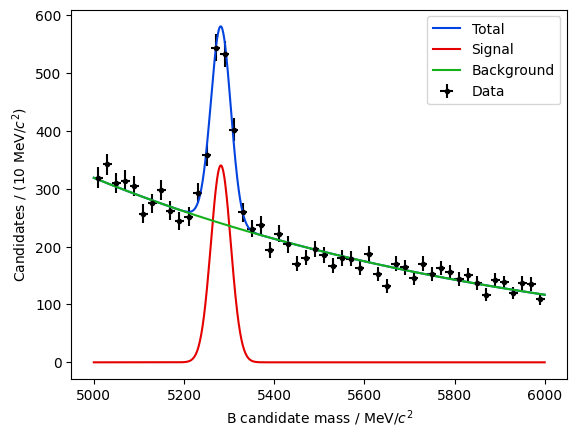

In [6]:
#Here we will use matplotlib to plot the data, then the total PDF, and the
#individual components. It is a little convoluted to normalise the PDFs
#correctly, there is probably a simpler way

import numpy

# plot the data as a histogram with a specified number of bins
bins = 50

#Going to use a "pretty" style of plotting...
y, bin_edges = numpy.histogram(data['B invariant mass'], bins=bins)
binwidth = bin_edges[1] - bin_edges[0]
x    = 0.5*(bin_edges[1:] + bin_edges[:-1])
xerr = 0.5*(bin_edges[1:] - bin_edges[:-1])
yerr = numpy.sqrt(y)

plt.errorbar(x, y, xerr=xerr, yerr=yerr, color='black', fmt='.',label='Data')

x_plot = numpy.linspace(mass.lower[0], mass.upper[0], num=1000)
tot_plot = (signalYield+backgroundYield)*binwidth*totalPDF.pdf(x_plot)
plt.plot(x_plot, tot_plot, color='xkcd:blue', label='Total')
sig_plot = signalYield*binwidth*signalPDF.pdf(x_plot)
plt.plot(x_plot, sig_plot, color='xkcd:red', label=r'Signal')
bkg_plot = backgroundYield*binwidth*backgroundPDF.pdf(x_plot)
plt.plot(x_plot, bkg_plot, color='xkcd:green', label='Background')
plt.xlabel(r'B candidate mass / MeV/$c^2$')
plt.ylabel(r'Candidates / (10 MeV/$c^2)$')
plt.legend()
plt.show()

In [7]:
#We have a signal yield and associated statistical uncertainty and a pretty plot.

#We need to consider, are the yield and uncertainty reliable? How could we check?

#Just because we've minimised our likelihood, that doesn't mean our PDF describes
#the data. Is the fit good?